# 神经风格迁移

In [1]:
# 导入需要的库
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import torchvision.models as models

In [2]:
# 定义内容损失
class ContentLoss(nn.Module):
    def __init__(self,content_feature):
        super(ContentLoss,self).__init__()
        self.content_feature = content_feature
        self.criterion = nn.MSELoss()
    
    # 前向传播
    def forward(self,output_feature):
        content_err = torch.tensor(0.).cuda()
        for name, feature in output_feature.items():
            content_err += self.criterion(feature,self.content_feature[name].detach())
        return content_err
        

In [18]:
# 定义风格损失
class StyleLoss(nn.Module):
    def __init__(self,style_features,style_weights):
        super(StyleLoss,self).__init__()
        self.style_features = style_features
        self.style_weights = style_weights
        # 计算风格Gram矩阵
        self.style_grams = self.get_grams(self.style_features)

    # 前向传播
    def forward(self,output_features):
        style_grams = self.get_grams(output_features)
        style_err = torch.tensor(0.).cuda()
        for name, gram in style_grams.items():
            style_err += self.style_weights[name]*torch.sum((gram-self.style_grams[name].detach())**2)
        return style_err
        
    # 计算Gram矩阵
    def get_grams(self,features):
        grams = {}
        for name, feature in features.items():
            _,c,h,w = feature.size()
            feature = feature.view(c,h*w).cuda()
            gram = torch.mm(feature,feature.t())
            grams[name] = gram.div(c*h*w)
        return grams

In [31]:
# Neural style transfer
class NST(nn.Module):
    def __init__(self,style_image,content_image,alpha,beta,gamma,style_features_name,content_feature_name,style_weights):
        super(NST,self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        # 保存图片尺寸，以用于图片恢复
        self.image_size = [content_image.height,content_image.width]
        # 保存所使用特征图的信息
        self.style_features_name = style_features_name
        self.content_feature_name = content_feature_name
        self.style_weights = style_weights
        # 加载VGG
        self.model = self.load_vgg_features()
        # 预处理
        self.style_image = self.preprocess(style_image)
        self.content_image = self.preprocess(content_image)
        # 获取特征图
        self.style_features = self.get_features(self.style_features_name,self.style_image)
        self.content_feature = self.get_features(self.content_feature_name,self.content_image)
        # 实例化损失
        self.ContentLoss = ContentLoss(self.content_feature)
        self.StyleLoss = StyleLoss(self.style_features,self.style_weights)
        # 结果
        self.output_image = nn.Parameter(self.content_image.clone(),requires_grad=True)
        # 用于添加正则化项
        self.relu = nn.ReLU()

    # 结合style_image的风格和content_image的内容
    def forward(self):
        content_feature = self.get_features(self.content_feature_name,self.output_image)
        style_features = self.get_features(self.style_features_name,self.output_image)
        content_err = self.ContentLoss(content_feature)
        style_err = self.StyleLoss(style_features)

        l_err = torch.sum(self.relu(-self.output_image) + self.relu(self.output_image-1))

        return self.alpha*content_err + self.beta*style_err + self.gamma*l_err


    # 加载vgg
    def load_vgg_features(self):
        model = models.vgg19(pretrained=True).features.cuda()
        # 配置参数微分状态
        for params in model.parameters():
            params.requires_grad_(False)
        return model

    # 图片预处理
    def preprocess(self,image):
        preprocess = transforms.Compose([
            transforms.Resize([256,256]),
            transforms.ToTensor()
        ])
        image = preprocess(image).unsqueeze(0).cuda()
        return image

    # 获取特征图
    def get_features(self,layers_name,input_tensor):
        features = {}
        for name,layer in self.model._modules.items():
            input_tensor = layer(input_tensor)
            if name in layers_name:
                features[layers_name[name]] = input_tensor
        return features

    # 读取图片
    def get_image(self):
        unloader = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToPILImage()
        ])
        image = self.output_image.clone().cpu()
        image = unloader(image.view(3, 256, 256))
        return image

    # 训练器
    @staticmethod
    def train(nst_model,epoch):
        optimizer = torch.optim.Adamax(nst_model.parameters())
        for i in range(epoch):
            optimizer.zero_grad()
            loss = nst_model()
            loss.backward()
            optimizer.step()
            train_loss = loss.item()
            if i % 100 == 0:
                print('epoch:',i,'loss:',train_loss)

In [32]:
alpha = 1
beta = 1000
gamma = 1000
style_features_name = {
    '0': 'conv1_1',
    '5': 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '28': 'conv5_1'
}
content_feature_name = {
    '21': 'conv4_2'
}
style_weights = {
    'conv1_1':0.2,
    'conv2_1':0.2,
    'conv3_1':0.2,
    'conv4_1':0.2,
    'conv5_1':0.2
}
content_image = Image.open('./images/content_image/content_image.jpeg')
style_image = Image.open('./images/style_image/style_image.jpeg')

# 实例化网络
nst = NST(
    style_image=style_image,
    content_image=content_image,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    style_features_name=style_features_name,
    content_feature_name=content_feature_name,
    style_weights=style_weights
).cuda()

In [35]:
# 调用训练器训练
NST.train(nst,300)

epoch: 0 loss: 29.525123596191406
epoch: 100 loss: 23.859092712402344
epoch: 200 loss: 17.211795806884766


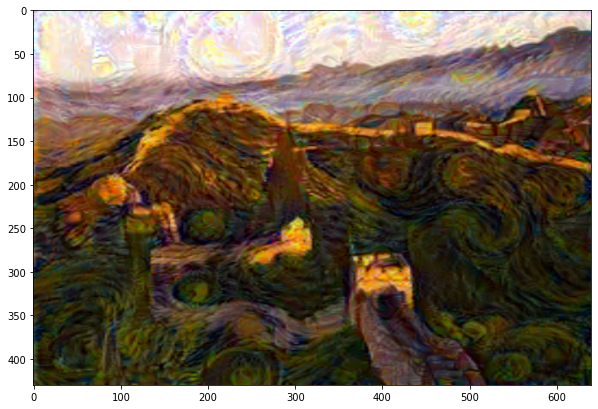

In [36]:
import matplotlib.pyplot as plt
a = nst.get_image()
plt.figure(figsize=(10,10))
plt.imshow(a)